100%|██████████| 9912422/9912422 [00:00<00:00, 10747674.07it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 5516951.03it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3685827.51it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 3846260.60it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])
Epoch: 0 | Loss: 1.5352 | Train Accuracy: 93.47
Epoch: 1 | Loss: 1.4945 | Train Accuracy: 96.96
Epoch: 2 | Loss: 1.4904 | Train Accuracy: 97.29
Epoch: 3 | Loss: 1.4866 | Train Accuracy: 97.63
Epoch: 4 | Loss: 1.4851 | Train Accuracy: 97.77
Epoch: 5 | Loss: 1.4831 | Train Accuracy: 97.95
Epoch: 6 | Loss: 1.4818 | Train Accuracy: 98.09
Epoch: 7 | Loss: 1.4814 | Train Accuracy: 98.12


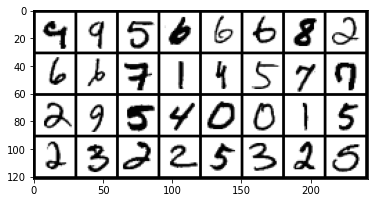

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

## for printing image (when DEBUGGING flag is set)
import matplotlib.pyplot as plt
import numpy as np

# Set this to true during development
DEBUGGING = True

## parameter denoting the batch size
BATCH_SIZE = 32

## transformations
## (Lambda function is to make digits black on white instead of white on black)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: 1-x)])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
print(trainset)
print(testset)

# Should print:
# Dataset MNIST
#     Number of datapoints: 60000
#     Root location: ./data
#     Split: Train
# Dataset MNIST
#     Number of datapoints: 10000
#     Root location: ./data
#     Split: Test

if DEBUGGING:
    # Display the 32 random training images in a batch
    def imshow(img):
        #img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    imshow(torchvision.utils.make_grid(images))

    # Look at the shapes of the tensors in a batch
    for images, labels in trainloader:
        print("Image batch dimensions:", images.shape)
        print("Image label dimensions:", labels.shape)
        break

    # Should print this:
    # Image batch dimensions: torch.Size([32, 1, 28, 28])
    # Image label dimensions: torch.Size([32])

## the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64 * 7 * 7, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = out.view(out.size(0), -1)
        out = out.flatten(start_dim = 1)
        logits = self.layer3(out)
        out = F.softmax(logits, dim=1)
        return out

model = MyModel()

if DEBUGGING:
    # Send a batch through and see what comes out
    for images, labels in trainloader:
        print("batch size:", images.shape)
        out = model(images)
        print(out.shape)
        break
    # Should print this:
    # batch size: torch.Size([32, 1, 28, 28])
    # torch.Size([32, 10])

learning_rate = 0.001
num_epochs = 25

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## utility function to compute accuracy
def get_accuracy(output, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

## train the model
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## commence training
    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(predictions, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

torch.save(model.state_dict(), 'mnist.pt')

dummy_input = torch.randn(1, 1, 28, 28).to(device)
input_names = [ "input_0" ]
output_names = [ "output_0" ]
torch.onnx.export(model, dummy_input, 'mnist.onnx', verbose=True, input_names=input_names, output_names=output_names)

In [7]:
type(model)

__main__.MyModel

In [3]:
type(device)

torch.device

In [5]:
%who torch.device

No variables match your requested type.


NameError: name 'mm' is not defined